In [1]:
import os

gpus = [2]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf 
import tensorflow.keras as keras
import numpy as np 
#from oe_acute import MNE
import pickle
import sys
import random
#from AE import MDSAE as ae
#from network_visualisation import plot_these_aud_weights
#import network_visualisation
#import quantify_aud_strfs
import matplotlib.pyplot as plt

### Allocate GPUs

In [3]:
gpus = [2] # Here I set CUDA to only see one GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1 

In [4]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print( [x.name for x in local_device_protos if x.device_type == 'GPU'] )

['/device:GPU:0']


### Model function

In [5]:
class Temporal_Specgram_CNN_Model(keras.Model):
    def __init__(self, **kwargs):
        super(Temporal_Specgram_CNN_Model, self).__init__()
        self.__dict__.update(kwargs)
        self.enc_1=keras.Sequential([
            keras.Input(shape=(16, 16, 1)),
#             keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu",),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation="relu",),
            tf.keras.layers.Flatten(),
            
            
        ])
        self.enc_dropout=tf.keras.layers.Dropout(0.5)
        self.enc_2=tf.keras.layers.Dense(units=256,activation='sigmoid', kernel_regularizer=keras.regularizers.L1(10**-3.5),)
        self.dec_recon=keras.Sequential([
            tf.keras.layers.Dense(units=8 * 8 * 256, activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5)),
            tf.keras.layers.Reshape(target_shape=(8, 8, 256)),
#             tf.keras.layers.Conv2DTranspose(
#                 filters=16, kernel_size=2, strides=(2, 2),  activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5), 
#             ),
            tf.keras.layers.Conv2DTranspose(
                filters=8, kernel_size=2, strides=(2, 2), activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5)
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=1, strides=(1, 1), kernel_regularizer=keras.regularizers.L1(10**-3.5)
            ),
        ])
        self.dec_pred=keras.Sequential([tf.keras.layers.Dense(units=16, kernel_regularizer=keras.regularizers.L1(10**-3.5))])
        self.recon_losses=[]
        self.pred_losses=[]
    @tf.function
    def get_loss(self, x_t, y_t):
        #print(x_t)#.shape
        x_hat, y_hat = self(tf.expand_dims(x_t, -1))
        pred_losses=tf.reduce_mean(tf.square(y_t - y_hat))
        
        recon_losses=tf.reduce_mean(tf.square(x_t - tf.squeeze(x_hat, -1)))

        
        return pred_losses,recon_losses

    @tf.function
    def get_gradients(self, x_t, y_t):
        with tf.GradientTape() as tape:
            pred_losses,recon_losses = self.get_loss(x_t, y_t)
            #tf.print(pred_losses, recon_losses)
            loss=pred_losses+0.5*recon_losses
            
        return loss, tape.gradient(loss, self.enc_1.trainable_variables+self.enc_2.trainable_variables+self.dec_recon.trainable_variables+self.dec_pred.trainable_variables)
    
    @tf.function
    def train_model(self, X_train, y_train):
        loss, gradients = self.get_gradients(X_train, y_train)
        self.optimizer.apply_gradients(zip(gradients, self.enc_1.trainable_variables+self.enc_2.trainable_variables+self.dec_recon.trainable_variables+self.dec_pred.trainable_variables))
        return loss

    @tf.function
    def compute_test_loss(self, X_test, y_test):
        x_hat, y_hat = self.predict(tf.expand_dims(X_test, -1))
        pred_losses=tf.reduce_mean(tf.square(y_test - y_hat))
        
        recon_losses=tf.reduce_mean(tf.square(X_test - tf.squeeze(x_hat, -1)))

        
        return pred_losses,recon_losses


    def call(self, input):
        latent=self.enc_1(input)
        latent=self.enc_dropout(latent, training=True)
        latent=self.enc_2(latent)
        return self.dec_recon(latent), self.dec_pred(latent)

    def predict(self, input):
        latent=self.enc_1(input)
        latent=self.enc_dropout(latent, training=False)
        latent=self.enc_2(latent)
        return self.dec_recon(latent), self.dec_pred(latent)


In [6]:
#model.enc.

In [7]:
#x_t, y_t = train_batch[0], train_batch[1]

In [8]:
#pred_losses,recon_losses=model.get_loss(x_t, y_t)

In [9]:
#pred_losses

### Load data

In [10]:
#def extract_spec_data(x_path, y_path, random_seed=None, global_normalize=False):
def extract_spec_data(x_path, y_path, random_seed=None):
    #all_curr=np.load(x_path,allow_pickle=True)
    #all_next=np.load(y_path,allow_pickle=True)
    all_curr = pickle.load(open(x_path, 'rb'))
    all_next = pickle.load(open(y_path, 'rb'))
    
    x_array = all_curr
    y_array = all_next

    #x_array = np.vstack(all_curr)
    #y_array = np.vstack(all_next)

    if random_seed is None:
        rand_idx=np.arange(0, np.shape(x_array)[0])
    else:
        np.random.seed(random_seed)
        rand_idx=np.random.choice(range(np.shape(x_array)[0]), size=np.shape(x_array)[0],replace=False)
    
    split_train_idx, split_val_idx = rand_idx[np.shape(x_array)[0]//10:],rand_idx[:np.shape(x_array)[0]//10] 
    x_train, x_val=np.asarray(x_array)[split_train_idx], np.asarray(x_array)[split_val_idx]
    y_train, y_val=np.asarray(y_array)[split_train_idx],np.asarray(y_array)[split_val_idx]
    
    #if global_normalize:
    #    x_train=x_train/x_train.max()
    #    y_train=y_train/y_train.max()
    #    x_val=x_val/x_val.max()
    #    y_val=y_val/y_val.max()
    return x_train,y_train,x_val,y_val

In [11]:
segs_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/segs_list_16.pkl'
next_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/next_list_16.pkl'

#x_train,y_train,x_val,y_val = extract_spec_data(segs_path, next_path, random_seed=0,global_normalize=True)
x_train1,y_train1,x_val1,y_val1 = extract_spec_data(segs_path, next_path, random_seed=0)

In [12]:
x_train = x_train1[:, :16, :]
x_val = x_val1[:, :16, :]
y_train = y_train1[:, :16]
y_val = y_val1[:, :16]

### Training network

Epoch 0, Train-Loss 0.02586805634200573
Epoch 1, Train-Loss 0.042931362986564636
Epoch 2, Train-Loss 0.024631988257169724
Epoch 3, Train-Loss 0.02788478694856167
Epoch 4, Train-Loss 0.022729631513357162
Epoch 5, Train-Loss 0.024003690108656883
Epoch 6, Train-Loss 0.01789757050573826
Epoch 7, Train-Loss 0.019721107557415962
Epoch 8, Train-Loss 0.021156208589673042
Epoch 9, Train-Loss 0.015912465751171112
Epoch 10, Train-Loss 0.007782127242535353
Epoch 11, Train-Loss 0.018873313441872597
Epoch 12, Train-Loss 0.015400153584778309
Epoch 13, Train-Loss 0.01788967102766037
Epoch 14, Train-Loss 0.01412546169012785
Epoch 15, Train-Loss 0.014795362949371338
Epoch 16, Train-Loss 0.017832648009061813
Epoch 17, Train-Loss 0.015187372453510761
Epoch 18, Train-Loss 0.01711355894804001
Epoch 19, Train-Loss 0.010669895447790623
Epoch 20, Train-Loss 0.01222964283078909
Epoch 21, Train-Loss 0.0109123345464468
Epoch 22, Train-Loss 0.012260456569492817
Epoch 23, Train-Loss 0.012336455285549164
Epoch 24, T

Epoch 194, Train-Loss 0.007204554975032806
Epoch 195, Train-Loss 0.004571268800646067
Epoch 196, Train-Loss 0.007118544541299343
Epoch 197, Train-Loss 0.0059296684339642525
Epoch 198, Train-Loss 0.00529691856354475
Epoch 199, Train-Loss 0.005827834829688072
Epoch 200, Train-Loss 0.005248269997537136
Epoch 201, Train-Loss 0.006767389830201864
Epoch 202, Train-Loss 0.005965727381408215
Epoch 203, Train-Loss 0.005892239045351744
Epoch 204, Train-Loss 0.006720329634845257
Epoch 205, Train-Loss 0.007087564095854759
Epoch 206, Train-Loss 0.004940824583172798
Epoch 207, Train-Loss 0.005129029508680105
Epoch 208, Train-Loss 0.007872088812291622
Epoch 209, Train-Loss 0.0062202224507927895
Epoch 210, Train-Loss 0.006882693152874708
Epoch 211, Train-Loss 0.009154962375760078
Epoch 212, Train-Loss 0.0063447849825024605
Epoch 213, Train-Loss 0.007031343877315521
Epoch 214, Train-Loss 0.007089040242135525
Epoch 215, Train-Loss 0.006511089392006397
Epoch 216, Train-Loss 0.0060272663831710815
Epoch 21

Epoch 385, Train-Loss 0.006793973036110401
Epoch 386, Train-Loss 0.005308971274644136
Epoch 387, Train-Loss 0.005738988984376192
Epoch 388, Train-Loss 0.005003008060157299
Epoch 389, Train-Loss 0.005374605767428875
Epoch 390, Train-Loss 0.006053150165826082
Epoch 391, Train-Loss 0.007606919854879379
Epoch 392, Train-Loss 0.007122277282178402
Epoch 393, Train-Loss 0.0051483348943293095
Epoch 394, Train-Loss 0.007688920013606548
Epoch 395, Train-Loss 0.005704872310161591
Epoch 396, Train-Loss 0.006090711802244186
Epoch 397, Train-Loss 0.005549689754843712
Epoch 398, Train-Loss 0.006829993333667517
Epoch 399, Train-Loss 0.005935576744377613
Epoch 400, Train-Loss 0.0059487484395504
Epoch 401, Train-Loss 0.0054137129336595535
Epoch 402, Train-Loss 0.006538406480103731
Epoch 403, Train-Loss 0.006720905192196369
Epoch 404, Train-Loss 0.005439866334199905
Epoch 405, Train-Loss 0.007272377144545317
Epoch 406, Train-Loss 0.00555410236120224
Epoch 407, Train-Loss 0.004846447147428989
Epoch 408, T

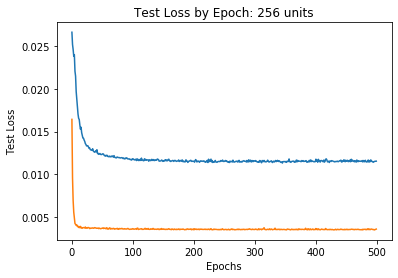

In [13]:
train_dset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_dset = train_dset.shuffle(buffer_size=x_train.shape[0]+256).batch(64)
test_losses = []

optimizer = tf.optimizers.Adam(1e-3)
model = Temporal_Specgram_CNN_Model(optimizer=optimizer)
x_val, y_val = x_val.astype(np.float32), y_val.astype(np.float32)
with tf.device('/device:gpu:2'):
#     tf.print('Training Fold {}'.format(index))
    #model.load_weights('./temporal_specgram_weights/initial')
    for epoch in range(500):
        #if epoch>250:
        #    model.optimizer.learning_rate=2e-4
        for step, train_batch in enumerate(train_dset):
            train_loss = model.train_model(train_batch[0], train_batch[1])

        tf.print('Epoch {}, Train-Loss {}'.format(epoch, train_loss), output_stream=sys.stdout)
        test_losses.append(model.compute_test_loss(x_val, y_val))
        
    plt.plot(test_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Test Loss by Epoch: {} units'.format(256))
    #plt.savefig('mnt/cube/srrudrar/temporal_model/loss_plots/{}units_loss.png'.format(256))

In [18]:
with tf.device('/device:gpu:2'):
    #model.save_weights('/mnt/cube/srrudrar/temporal_model/temporal_model_weights/temp_256_l1_3_5_500epoch_64batch.h5')
    #predicted = model.full_model(x_val)
    enc_train1 = model.enc_2(model.enc_dropout(model.enc_1(x_train[:15000,:,:][:,:,:,np.newaxis])))
    enc_train2 = model.enc_2(model.enc_dropout(model.enc_1(x_train[15000:30000,:,:][:,:,:,np.newaxis])))
    enc_train3 = model.enc_2(model.enc_dropout(model.enc_1(x_train[30000:,:,:][:,:,:,np.newaxis])))
    enc_val = model.enc_2(model.enc_dropout(model.enc_1(x_val[:,:,:,np.newaxis])))
    #tf.print(predicted.shape)
    tf.print(enc_train1.shape)
    tf.print(enc_train2.shape)
    tf.print(enc_train3.shape)
    tf.print(enc_val.shape)

TensorShape([15000, 256])
TensorShape([15000, 256])
TensorShape([18855, 256])
TensorShape([5428, 256])


In [ ]:
import json

In [ ]:
json.dump([float(i[0].numpy()) for i in test_losses],open('pred_only_64_channels_dropout_test_loss.json', 'w'))